In [1]:
# libraries
import numpy as np
import pandas as pd
from numpy import array
import random
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [4]:
# Use same random value whenever needed ran=42
ran = 27
kmax=250; kstep=1
trainsize=.8; testsize=.2; #valsize=.1

In [5]:
#Loading Abalone Data set
abalone_Xcategorycolnames = ['Sex']
abalone_Xcolnames = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
abalone_Ycolname = 'Rings'
abalone = pd.read_csv("abalone.csv", sep=',')
abalone.columns=abalone_Xcategorycolnames + abalone_Xcolnames+[abalone_Ycolname]

# One hot encoding for categorical data 'Sex'
data = abalone['Sex']
values = array(data)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
df_sex_alternate = pd.DataFrame(onehot_encoded, columns=["Female", "Infant", "Male"])

abalone_raw = abalone.drop(columns=['Sex'])
abalone_raw = pd.concat([abalone_raw,df_sex_alternate],axis=1)
abalone_Xcolnames = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight','Female', 'Infant', 'Male']


In [6]:
#Loading Wine Data set
wine_r = pd.read_csv("winequality-red.csv", sep=';')
wine_w = pd.read_csv("winequality-white.csv", sep=';')

C = 'color'

wine_w[C]= np.zeros(wine_w.shape[0])
wine_r[C]= np.ones(wine_r.shape[0])

wine_raw = pd.concat([wine_w,wine_r])
wine_Xcolnames = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']
wine_Ycolname = 'quality'

In [7]:
# Any Dataset : Assign the data to variables
abalone_X = abalone_raw[abalone_Xcolnames]
abalone_Y = abalone_raw[abalone_Ycolname]

wine_X = wine_raw[wine_Xcolnames]
wine_Y = wine_raw[wine_Ycolname]

#### Normalization for Abalone dataset

We have to normalize **all** the features in the dataset. We do this in order to get a standard form of the data. Before applying PCA or LDA we need to normalize (standardize) data in order to capture the variance of each feature equally. As we observed in the above output the standard deviation of each feature differs a lot. Some features has  a larger deviation compared to other features such as, "Active" compared to "Case_Fatality_Ratio" or "Day". 

**Point to note-**
PCA requires the two conditions for the best result:
1. Data should be centered. - _This helps in finding the optimal PCs._
2. All features should have almost same variance. - _This helps in capturing equal variance of all the features._

So, if we do not normalize data before applying PCA, it will not be able to capture the variance of each feature equally. So, features with high standard deviation will get more prefernce over the features with lower value of variance. It may happen that PCA will totally fail to capture some feature's variance at all.

**Hence, before PCA and LDA we will normalize the data using Min-Max normalization. By using normalization, we can convert the data in the range [0,1]**

In [8]:
# Normalize entire dataset of Abalone and Wine

X = abalone_X
scaler = MinMaxScaler()
min_max_abalonedata = scaler.fit_transform(abalone_X)

X = wine_X
scaler = MinMaxScaler()
min_max_winedata = scaler.fit_transform(wine_X)

## 1. Representation learning

### 1.1 Produce a plot of the data in the two lowest dimensions for PCA and LDA, using easily distinguishable colours and markers to indicate the labels of each datapoint. Also use the t-SNE method to produce a 2D plot of the datasets. You now have three 2-dimensional plots of each dataset. Comment briefly on any interesting patterns that emerge.

**Representation Learning**: It is a data pre-processing technique where we find minimum number of components to represent our data. It helps in dimensionality reduction. It reduces the complexity of data and makes data more easy for any model to learn. It captures the essence and trend of data in such a way that there is either no or minimum loss of data. It helps in removing redundant and derived features.

Here, we will examine two methods:
1. Prinicipal Component Analysis (PCA)
2. Linear Discriminant Analysis (LDA)

Major differences between these two approaches are:
1. PCA is unsupervised technique where it does not use the target for finding the optimal directions. Whereas, LDA is a supervised technique with uses the target for finding N components which are {number_of_classes - 1}.

2. PCA finds the optimal directions which captures maximum variance of all features whereas LDA finds optimal directions where it can have maximum class separability. 

#### PCA for Abalone and Wine Dataset

In [9]:
from sklearn.decomposition import PCA

abalone_pca = PCA(n_components = 2)
principalComponents_abalone = abalone_pca.fit_transform(min_max_abalonedata)
final_abalone_pca = principalComponents_abalone

wine_pca = PCA(n_components = 2)
principalComponents_wine = wine_pca.fit_transform(min_max_winedata)
final_wine_pca = principalComponents_wine

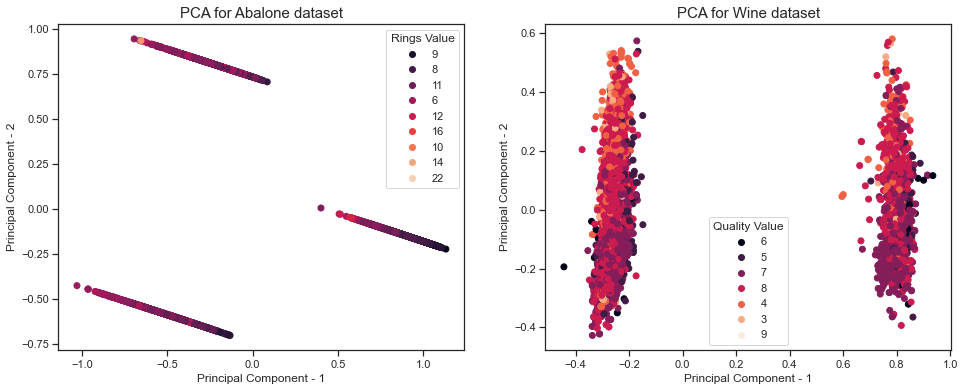

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Scatter Plot for Abalone data
sp_names = [ 9,  8, 11,  6, 12, 16, 10, 14, 22,  7, 15, 13,  3, 19, 17, 21, 18, 4, 5, 20, 26, 23, 24, 25,  2, 29, 27,  1]
temp = ax1.scatter(final_abalone_pca[:,0], final_abalone_pca[:,1], c = abalone_Y)
ax1.set(xlabel='Principal Component - 1', ylabel='Principal Component - 2')
ax1.set_title("PCA for Abalone dataset",fontsize=15)
ax1.legend(handles=temp.legend_elements()[0], title="Rings Value", labels=sp_names)

# Scatter Plot for Wine data
sp_names = [6, 5, 7, 8, 4, 3, 9]
temp = ax2.scatter(final_wine_pca[:,0], final_wine_pca[:,1], c = wine_Y)
ax2.set(xlabel='Principal Component - 1', ylabel='Principal Component - 2')
ax2.set_title("PCA for Wine dataset",fontsize=15)
ax2.legend(handles=temp.legend_elements()[0], title="Quality Value", labels=sp_names)

PCA does not embody 100% of the information in the dataset. Each PC explains certain % of your
orignal data the goal is to select enough PC’s which accounts for >90% of the orignal dataset

#### LDA for Abalone & Wine Dataset

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [13]:
abalone_lda = LDA(n_components = 2)
abalone_lda_rings = abalone_lda.fit_transform(min_max_abalonedata, abalone_Y)
final_abalone_lda = abalone_lda_rings

wine_lda = LDA(n_components = 2)
wine_lda_quality = wine_lda.fit_transform(min_max_winedata, wine_Y)
final_wine_lda = wine_lda_quality

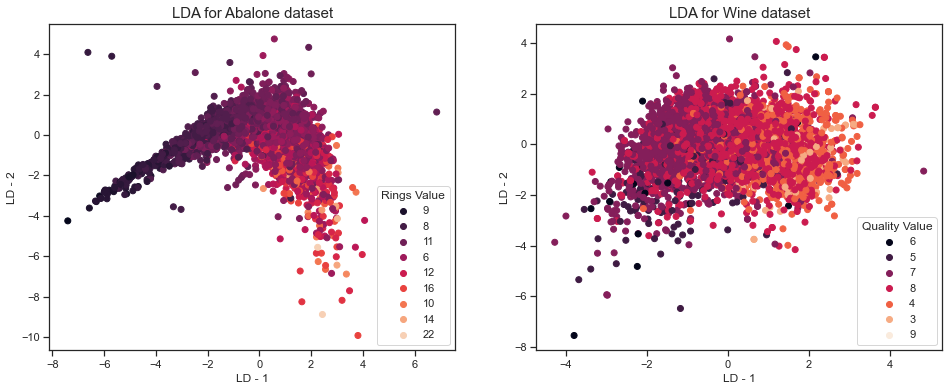

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Scatter Plot for Abalone data
sp_names = [ 9,  8, 11,  6, 12, 16, 10, 14, 22,  7, 15, 13,  3, 19, 17, 21, 18, 4, 5, 20, 26, 23, 24, 25,  2, 29, 27,  1]
temp = ax1.scatter(abalone_lda_rings[:,0], abalone_lda_rings[:,1], c = abalone_Y)
ax1.set(xlabel='LD - 1', ylabel='LD - 2')
ax1.set_title("LDA for Abalone dataset",fontsize=15)
ax1.legend(handles=temp.legend_elements()[0], title="Rings Value", labels=sp_names)

#Scatter Plot for Wine data
sp_names = [6, 5, 7, 8, 4, 3, 9]
temp = ax2.scatter(wine_lda_quality[:,0], wine_lda_quality[:,1], c = wine_Y)
ax2.set(xlabel='LD - 1', ylabel='LD - 2')
ax2.set_title("LDA for Wine dataset",fontsize=15)
ax2.legend(handles=temp.legend_elements()[0], title="Quality Value", labels=sp_names)

#### T-SNE for Abalone & Wine Dataset

In [15]:
import time
from sklearn.manifold import TSNE

In [16]:
time_start = time.time()

abalone_tsne = TSNE(n_components=2, random_state = ran)
abalone_tsne_results = abalone_tsne.fit_transform(min_max_abalonedata)

wine_tsne = TSNE(n_components=2, random_state = ran)
wine_tsne_results = wine_tsne.fit_transform(min_max_winedata)

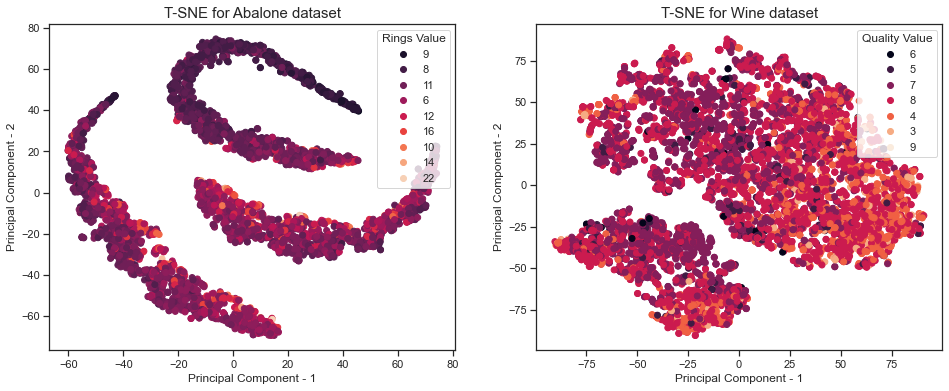

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Scatter Plot for Abalone data

# These are unique values from target variable
sp_names = [ 9,  8, 11,  6, 12, 16, 10, 14, 22,  7, 15, 13,  3, 19, 17, 21, 18, 4, 5, 20, 26, 23, 24, 25,  2, 29, 27,  1]

temp = ax1.scatter(abalone_tsne_results[:,0], abalone_tsne_results[:,1], c = abalone_Y)
ax1.set(xlabel='Principal Component - 1', ylabel='Principal Component - 2')
ax1.set_title("T-SNE for Abalone dataset",fontsize=15)
ax1.legend(handles=temp.legend_elements()[0], title="Rings Value", labels=sp_names)

#Scatter Plot for Wine data

# These are unique values from target variable
sp_names = [6, 5, 7, 8, 4, 3, 9]

temp = ax2.scatter(wine_tsne_results[:,0], wine_tsne_results[:,1], c = wine_Y)
ax2.set(xlabel='Principal Component - 1', ylabel='Principal Component - 2')
ax2.set_title("T-SNE for Wine dataset",fontsize=15)
ax2.legend(handles=temp.legend_elements()[0], title="Quality Value", labels=sp_names)

### 1.2 Produce a scree-plot to look at the cumulative variance represented by the PCA eigenvectors.


PCA does not embody 100% of the information in the dataset. Each PC explains certain % of your
orignal data the goal is to select enough PC’s which accounts for >90% of the orignal dataset

In [18]:
# Applying PCA for getting Scree plot
abalone_pca_scree_plot = PCA(n_components = 10)
abalone_pca_scree_plot.fit_transform(min_max_abalonedata)

wine_pca_scree_plot = PCA(n_components = 12)
wine_pca_scree_plot.fit_transform(min_max_winedata)

array([[-0.29889712, -0.3376224 ,  0.0574388 , ..., -0.00793004,
        -0.00385996,  0.00276509],
       [-0.24191314, -0.08455597, -0.11084928, ..., -0.0274995 ,
        -0.04790911,  0.01061602],
       [-0.22505237, -0.03682141,  0.02813743, ...,  0.02065987,
         0.03443021, -0.01320649],
       ...,
       [ 0.7907868 ,  0.11193757, -0.15830506, ..., -0.01235291,
         0.03228585,  0.01776892],
       [ 0.80867838,  0.03140713, -0.30083552, ..., -0.02832124,
         0.05588476, -0.00388698],
       [ 0.75111114,  0.10230613, -0.05437899, ..., -0.05014694,
        -0.016713  ,  0.01292444]])

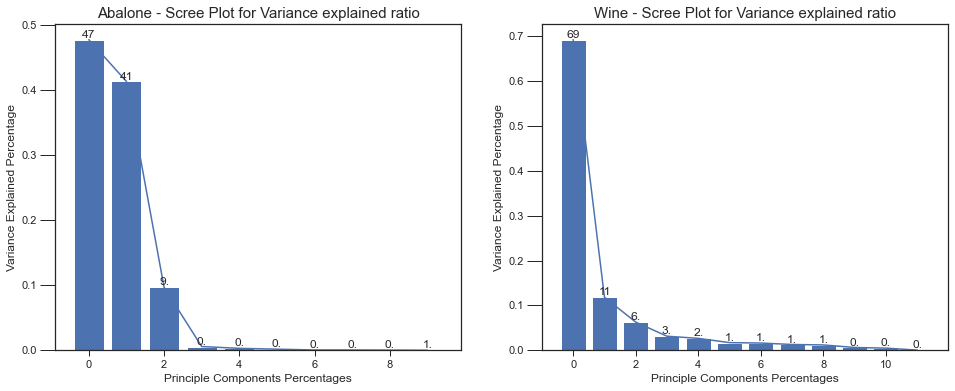

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

### Scree_plot for Abalone dataset ###
num_components = len(abalone_pca_scree_plot.explained_variance_ratio_)
index = np.arange(num_components)
values = abalone_pca_scree_plot.explained_variance_ratio_

ax1.bar(index, values)
ax1.plot(index, values)
for val in range(num_components):
    ax1.annotate(r"%s" %((str(values[val]*100)[:2])), (index[val],values[val]),va = 'bottom', ha = 'center')
    ax1.xaxis.set_tick_params(width = 1)
    ax1.yaxis.set_tick_params(width = 1, length = 15)
    ax1.set_title('Abalone - Scree Plot for Variance explained ratio', size=15)
    ax1.set_xlabel("Principle Components Percentages")
    ax1.set_ylabel("Variance Explained Percentage")

    
### Scree_plot for Wine dataset ###
num_components = len(wine_pca_scree_plot.explained_variance_ratio_)
index = np.arange(num_components)
values = wine_pca_scree_plot.explained_variance_ratio_

ax2.bar(index, values)
ax2.plot(index, values)
for val in range(num_components):
    ax2.annotate(r"%s" %((str(values[val]*100)[:2])), (index[val],values[val]),va = 'bottom', ha = 'center')
    ax2.xaxis.set_tick_params(width = 1)
    ax2.yaxis.set_tick_params(width = 1, length = 15)
    ax2.set_title('Wine - Scree Plot for Variance explained ratio', size=15)
    ax2.set_xlabel("Principle Components Percentages")
    ax2.set_ylabel("Variance Explained Percentage")

**For Abalone dataset:
As seen from the above scree plot, the first three principle components contributes for >95% of the information. Here PC1, PC2 and PC3 represents 99% of the information.**

**For Wine dataset:
As seen from the above scree plot, the first five principle components contributes for >90% of the information. Those 5 principle components contribute to 91% of the information.**

#### 1.3 You now want to experimentally find the best reduced dimensionality for the dataset with respect to how it impacts the accuracy of a classifier. Produce a plot that shows accuracy of your kNN classifier against number of reduced dimensions being used. The dimensions should listed in increasing order from 2 up to D, the original dimensionality of the dataset. For the kNN classifier, you should choose the best one you found from asg1, one of the weighted versions using a normalized dataset. Comment briefly on the difference in accuracy from asg1

Abalone - Test Accuracy is 0.215311004784689, with 2 components
Abalone - Test Accuracy is 0.21889952153110048, with 3 components
Abalone - Test Accuracy is 0.2595693779904306, with 4 components
Abalone - Test Accuracy is 0.26674641148325356, with 5 components
Abalone - Test Accuracy is 0.2727272727272727, with 6 components
Abalone - Test Accuracy is 0.27392344497607657, with 7 components
Abalone - Test Accuracy is 0.27392344497607657, with 8 components
Abalone - Test Accuracy is 0.26674641148325356, with 9 components
Abalone - Test Accuracy is 0.26674641148325356, with 10 components


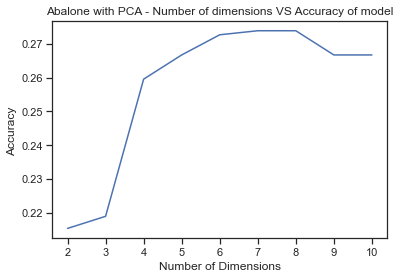

Wine - Test Accuracy is 0.6253846153846154, with 2 components
Wine - Test Accuracy is 0.6523076923076923, with 3 components
Wine - Test Accuracy is 0.68, with 4 components
Wine - Test Accuracy is 0.6761538461538461, with 5 components
Wine - Test Accuracy is 0.6792307692307692, with 6 components
Wine - Test Accuracy is 0.6915384615384615, with 7 components
Wine - Test Accuracy is 0.6953846153846154, with 8 components
Wine - Test Accuracy is 0.686923076923077, with 9 components
Wine - Test Accuracy is 0.6876923076923077, with 10 components
Wine - Test Accuracy is 0.693076923076923, with 11 components


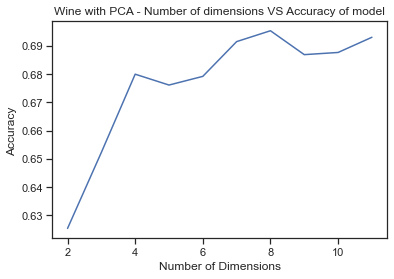

In [20]:
testing_accuracy_abalone = []
testing_accuracy_wine = []

# Plot for Abalone data
for n_comp in range(2,11):
    abalone_exp = PCA(n_components = n_comp)
    pc_abalone_exp = abalone_exp.fit_transform(min_max_abalonedata)
    final_abalone_exp = pc_abalone_exp

    column_names = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4', 'Principal Component 5', 'Principal Component 6', 'Principal Component 7', 'Principal Component 8', 'Principal Component 9', 'Principal Component 10']
    data_pca_exp = pd.DataFrame(final_abalone_exp, columns = column_names[:n_comp])

    X = data_pca_exp
    Y = abalone_Y
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state = ran)

    # Defining KNN model with the best found value of paramter K =78
    abalone_manhattan_knn_model_pca = KNeighborsClassifier(weights='distance', n_neighbors=78, p=1)
    abalone_manhattan_knn_model_pca.fit(X_train,y_train)
    Y_test_pred = abalone_manhattan_knn_model_pca.predict(X_test)
    print("Abalone - Test Accuracy is {}, with {} components".format(accuracy_score(y_test,Y_test_pred), n_comp))            
    testing_accuracy_abalone.append(accuracy_score(y_test,Y_test_pred))
plt.plot(range(2,11),testing_accuracy_abalone)
plt.title('Abalone with PCA - Number of dimensions VS Accuracy of model')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy ')
plt.show()

# Plot for Wine data
for n_comp in range(2,12):
    wine_exp = PCA(n_components = n_comp)
    pc_wine_exp = wine_exp.fit_transform(min_max_winedata)
    final_wine_exp = pc_wine_exp

    X = final_wine_exp
    Y = wine_Y
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state = ran)

    # Defining KNN model with the best found value of paramter K =58
    wine_manhattan_knn_model = KNeighborsClassifier(weights='distance', n_neighbors=58, p=1)
    wine_manhattan_knn_model.fit(X_train,y_train)
    Y_test_pred = wine_manhattan_knn_model.predict(X_test)
    print("Wine - Test Accuracy is {}, with {} components".format(accuracy_score(y_test,Y_test_pred), n_comp))            
    testing_accuracy_wine.append(accuracy_score(y_test,Y_test_pred))
plt.plot(range(2,12),testing_accuracy_wine)
plt.title('Wine with PCA - Number of dimensions VS Accuracy of model')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy ')
plt.show()

**Abalone with PCA: From the above plot of Accuracy vs Dimension, we can observe that we are able to achieve highest accuracy 27.39% for 7 dimensions.**

**Wine with PCA: From the above plot of Accuracy vs Dimension, we can observe that we are able to achieve highest accuracy 69.53% for 8 dimensions.**

#### 1.4 Now run the same analysis as in Question 3 using the LDA method.

Abalone - Test Accuracy is 0.26555023923444976, with 2 components
Abalone - Test Accuracy is 0.28588516746411485, with 3 components
Abalone - Test Accuracy is 0.2811004784688995, with 4 components
Abalone - Test Accuracy is 0.2822966507177033, with 5 components
Abalone - Test Accuracy is 0.29545454545454547, with 6 components
Abalone - Test Accuracy is 0.27392344497607657, with 7 components
Abalone - Test Accuracy is 0.29904306220095694, with 8 components
Abalone - Test Accuracy is 0.27751196172248804, with 9 components
Abalone - Test Accuracy is 0.27751196172248804, with 10 components


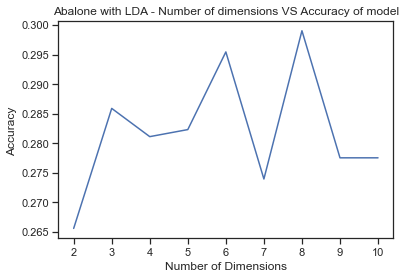

Test Accuracy is 0.6538461538461539, with 2 components
Test Accuracy is 0.67, with 3 components
Test Accuracy is 0.6761538461538461, with 4 components
Test Accuracy is 0.6846153846153846, with 5 components
Test Accuracy is 0.676923076923077, with 6 components


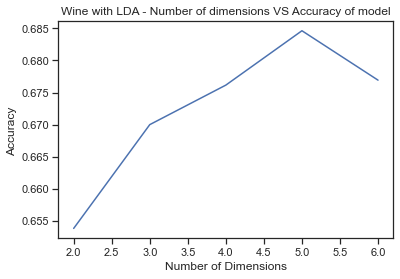

In [21]:
testing_accuracy_abalone = []
testing_accuracy_wine = []

for n_comp in range(2,11):
    abalone_lda = LDA(n_components = n_comp)
    abalone_lda_exp = abalone_lda.fit_transform(min_max_abalonedata, abalone_Y)
    final_abalone_exp = abalone_lda_exp

    X = final_abalone_exp
    Y = abalone_Y
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state = ran)

    # Defining KNN model with the best found value of paramter K =78
    abalone_manhattan_knn_model_lda = KNeighborsClassifier(weights='distance', n_neighbors=78, p=1)
    abalone_manhattan_knn_model_lda.fit(X_train,y_train)
    Y_test_pred = abalone_manhattan_knn_model_lda.predict(X_test)
    print("Abalone - Test Accuracy is {}, with {} components".format(accuracy_score(y_test,Y_test_pred), n_comp))            
    testing_accuracy_abalone.append(accuracy_score(y_test,Y_test_pred))

plt.plot(range(2,11),testing_accuracy_abalone)
plt.title('Abalone with LDA - Number of dimensions VS Accuracy of model')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy ')
plt.show()

for n_comp in range(2,7):
    wine_lda = LDA(n_components = n_comp)
    wine_lda_exp = wine_lda.fit_transform(min_max_winedata, wine_Y)
    final_wine_exp = wine_lda_exp

    X = final_wine_exp
    Y = wine_Y
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state = ran)

    # Defining KNN model with the best found value of paramter K =58
    wine_manhattan_knn_model = KNeighborsClassifier(weights='distance', n_neighbors=58, p=1)
    wine_manhattan_knn_model.fit(X_train,y_train)
    Y_test_pred = wine_manhattan_knn_model.predict(X_test)
    print("Test Accuracy is {}, with {} components".format(accuracy_score(y_test,Y_test_pred), n_comp))            
    testing_accuracy_wine.append(accuracy_score(y_test,Y_test_pred))

plt.plot(range(2,7),testing_accuracy_wine)
plt.title('Wine with LDA - Number of dimensions VS Accuracy of model')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy ')
plt.show()


**Abalone with LDA: From the above plot of Accuracy vs Dimension, we can observe that we are able to achieve highest accuracy of 29.9% for 8 dimensions.**

**Wine with LDA: From the above plot of Accuracy vs Dimension, we can observe that we are able to achieve highest accuracy of 68.4% with 5  dimensions.**

In [22]:
# Creating 6 different datasets from the above analysis
# We already have raw data as 'abalone_raw' and 'wine_raw'

# Creating abalone_pca data
abalone_exp = PCA(n_components = 7)
pc_abalone_exp = abalone_exp.fit_transform(min_max_abalonedata)
final_abalone_exp = pc_abalone_exp
abalone_pca = pd.DataFrame(final_abalone_exp, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])

# Creating abalone_lda data
abalone_lda = LDA(n_components = 8)
abalone_lda_exp = abalone_lda.fit_transform(min_max_abalonedata, abalone_Y)
final_abalone = abalone_lda_exp
abalone_lda = pd.DataFrame(final_abalone, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])

# Creating wine_pca data
wine_exp = PCA(n_components = 8)
pc_wine_exp = wine_exp.fit_transform(min_max_winedata)
final_wine_exp = pc_wine_exp
wine_pca = pd.DataFrame(final_wine_exp, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7', 'PC8'])

# Creating wine_lda data
wine_lda = LDA(n_components = 5)
wine_lda_exp = wine_lda.fit_transform(min_max_winedata, wine_Y)
final_wine_exp = wine_lda_exp
wine_lda = pd.DataFrame(final_wine_exp, columns=['PC1','PC2','PC3','PC4','PC5'])

abalone_raw = abalone_raw.drop(columns = ['Rings'])
wine_quality_col = wine_raw['quality']
wine_raw = wine_raw.drop(columns = ['quality'])

six_datasets = [abalone_raw, abalone_pca, abalone_lda, wine_raw, wine_pca, wine_lda]
six_datasets_name = ['Abalone raw', 'Abalone PCA', 'Abalone LDA', 'Wine raw', 'Wine PCA', 'Wine LDA']

## 2. Naive Bayes Classifier

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#### 2.1 Use 5-fold cross validation to compare both versions of Naive Bayes against your previous best results from kNN. Do this on all 4 (or 6) of your datasets and produce a table comparing the accuracies.

As we have first 3 datasets for Abalone study and rest of them  are for Wine , we are taking the y value accordingly. min-max normalisation is used for normalising the datasets. The datasets are then divided to train-test sets with test size of 20% and random state as 27.

We will be doing grid search over Alpha (0 or 1) to get the best model for each dataset. Here Alpha tells us if smoothing is done or not. We are using 5 fold CV for each value of alpha and then for the best model (based on the model getting max mean cv score) we are also finding its testing accuracy.

In [24]:
comp_nb_values = []
mult_nb_values = []
for i in range(6):
    dataset = six_datasets[i]

    if(i<=2):
        y= abalone_Y
    else:
        y = wine_Y
        
    dataset_normalized = (dataset-dataset.min())/(dataset.max()-dataset.min())
    
    X_train,X_test,y_train,y_test = train_test_split(dataset_normalized,y,test_size=testsize,random_state=ran)
    params = { 'alpha' : [0]}
    clf = GridSearchCV(ComplementNB(), params, cv=5,scoring="accuracy")
    clf.fit(X_train, y_train)    

    y_pred = clf.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    comp_nb_values.append(test_accuracy)
    
    clf = GridSearchCV(MultinomialNB(), params, cv=5,scoring="accuracy")
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    mult_nb_values.append(test_accuracy)
    
comp_nb_values = pd.DataFrame(comp_nb_values, columns=['Complement Naive Bayes'])
mult_nb_values = pd.DataFrame(mult_nb_values, columns=['Multinomial Naive Bayes'])
data_list = pd.DataFrame(six_datasets_name, columns=['Datasets'])

We will be using the KNN classifier accuracy we got from assignment 1 for abalone_raw(29%) and wine_raw(69.38%).  Also, using the results we got above, accracy we got will be abalone_pca=27.39%, abalone_lda=29.9%, wine_pca=69.35%, wine_lda=67%

In [25]:
# Creating a table to compare accuracies
knn_accuracies = pd.DataFrame(['0.29','0.2739','0.299','0.6938','0.6935','0.67'], columns=['KNN'])
table = pd.concat([data_list, comp_nb_values, mult_nb_values, knn_accuracies],axis=1)
table.style.hide_index()

Datasets,Complement Naive Bayes,Multinomial Naive Bayes,KNN
Abalone raw,0.209330,0.228469,0.29
Abalone PCA,0.196172,0.151914,0.2739
Abalone LDA,0.239234,0.151914,0.299
Wine raw,0.410769,0.472308,0.6938
Wine PCA,0.410769,0.438462,0.6935
Wine LDA,0.420769,0.438462,0.67


#### 2.2 Complement Naive Bayes is meant to perform better for unbalanced datasets, since our datasets our unbalanced, this seems appropriate, does it make much difference? Try to explain why either way.

As can be seen from the table, Complement NB has worse accuracy than Multinomial NB on virtually all occasions (with the exception of 1 or 2). The difference between the two, however, is minor ( a few percent in testing accuracy).
Since our Abalone data is unbalanced, Complement NB performs better for Abalone PCA and Abalone LDA. For imbalanced datasets used in text classification problems, the Complement NB outperforms the Multinomail NB. However, because we are not working with text in our application, it makes no difference.

## 3. Decision Trees Classifier

#### 3.1 Use 5-fold cross validation and a range of parameter values to evaluate the best settings for classification on each dataset.  the maximum depth of trees

We will be doing grid search over max tree depth ( over a range starting from 4 going upto 150) to get the best model for each 
dataset. We are using 5 fold CV for each value of max tree depth and then for the best model ( based on the model getting max
mean cv score) we are also finding its testing accuracy.

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [57]:
mdepth_range = [4,5,6,7,8,9,10,15,20,25,30,40,50,60,70,80,90,100,125,150]
for i in range(6):
    dataset = six_datasets[i]
    if(i<=2):
        y= abalone_Y
    else:
        y = wine_Y
    
    params = {'max_depth':mdepth_range}
    X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=0.2,random_state=27)
    
    clf = GridSearchCV(DecisionTreeClassifier(random_state=27), params, cv=5,scoring="accuracy")
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print('Decision Tree, '+ str(clf.best_params_) + ' '+ six_datasets_name[i] + ', Accuracy is ' + str(metrics.accuracy_score(y_test,y_pred)))

Decision Tree, {'max_depth': 4} Abalone raw, Accuracy is 0.284688995215311
Decision Tree, {'max_depth': 4} Abalone PCA, Accuracy is 0.23564593301435408
Decision Tree, {'max_depth': 5} Abalone LDA, Accuracy is 0.27392344497607657
Decision Tree, {'max_depth': 30} Wine raw, Accuracy is 0.5961538461538461
Decision Tree, {'max_depth': 30} Wine PCA, Accuracy is 0.5961538461538461
Decision Tree, {'max_depth': 25} Wine LDA, Accuracy is 0.5946153846153847


#### 3.2 Produce a plot showing the mean accuracy above parameter.

Decision Tree, {'max_depth': 4} Abalone raw, Accuracy is 0.284688995215311


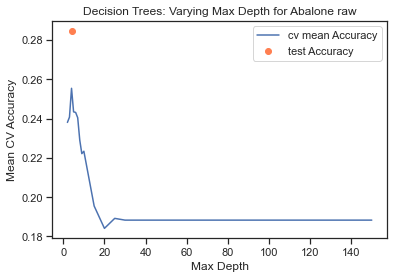

Decision Tree, {'max_depth': 3} Abalone PCA, Accuracy is 0.25239234449760767


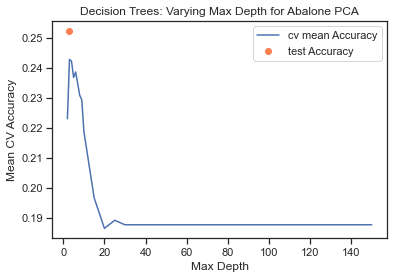

Decision Tree, {'max_depth': 5} Abalone LDA, Accuracy is 0.27392344497607657


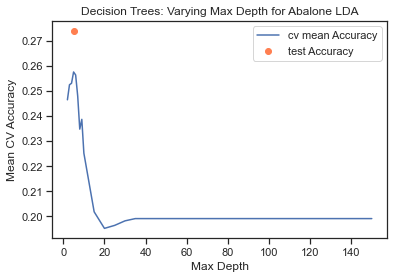

Decision Tree, {'max_depth': 30} Wine raw, Accuracy is 0.5961538461538461


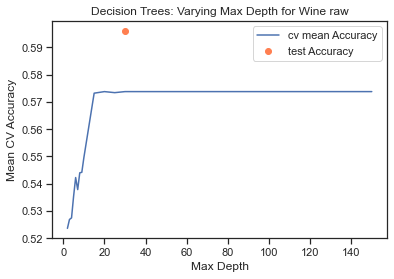

Decision Tree, {'max_depth': 30} Wine PCA, Accuracy is 0.5961538461538461


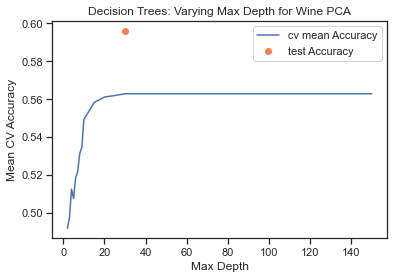

Decision Tree, {'max_depth': 25} Wine LDA, Accuracy is 0.5946153846153847


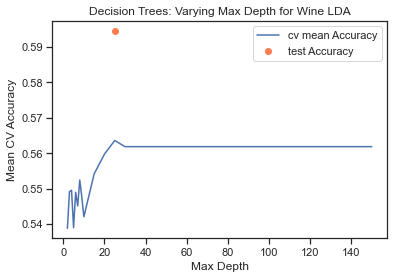

In [58]:
for i in range(6):
    dataset= six_datasets[i]

    if(i<=2):
        y= abalone_Y
    else:
        y = wine_Y
        
    params = {'max_depth':[2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100,125,150]}

    X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=testsize,random_state=ran)
    
    clf = GridSearchCV(DecisionTreeClassifier(random_state=ran), params, cv=5,scoring="accuracy")

    clf.fit(X_train, y_train)
    
    means = clf.cv_results_
    y_pred = clf.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    
    print('Decision Tree, '+ str(clf.best_params_) + ' '+ six_datasets_name[i] + ', Accuracy is ' + str(test_accuracy))

    plt.title('Decision Trees: Varying Max Depth for ' + str(six_datasets_name[i]))
    plt.plot(clf.cv_results_['param_max_depth'],clf.cv_results_['mean_test_score'], label = 'cv mean Accuracy')
    plt.scatter(clf.best_params_['max_depth'],test_accuracy, label = 'test Accuracy', c = 'coral')
    plt.legend()
    plt.xlabel('Max Depth')
    plt.ylabel('Mean CV Accuracy')
    plt.show()

The accuracy of the Abalone Dataset grows as the tree max increases up to a point, then begins to decline as the max depth 
increases, and eventually plateaus as the max depth increases after a point(25). We can observe that the testing accuracy was 
similar for all three Abalone datasets ( in range of 25-28 percent)

The accuracy of the Wine Dataset grows as the tree max increases up to a point, then plateaus as the max depth increases. We can
observe that the testing accuracy was similar across all three Wine datasets ( in range of 56-60 percent)

#### 3.3 Interpretability: Use the decision tree library functions, to examine the final resulting splitting rules used for the trees. Do they indicate any interesting patterns that explain the data? Can you find support for this from any analysis you’ve done or see on this dataset previously? For this part, use original raw feature space only.

Here we will be looking at the effects of splitters on the accuracy by doing a grid search on the following two combinations
<ul>
<li> Max depth and splitter. The splitter is used to decide which feature and which threshold is used.Using best, the model if taking the feature with the highest importance. Using random, the model if taking the feature randomly but with the same distribution
 <li> Max Depth and criterion. Critierion tells us which function to use if we want to split or not. It is either Gini or Entropy. The Critierion will define the importance of each feature for the classification
</ul>

decision Tree, {'max_depth': 4, 'splitter': 'best'} Abalone raw, 0.284688995215311


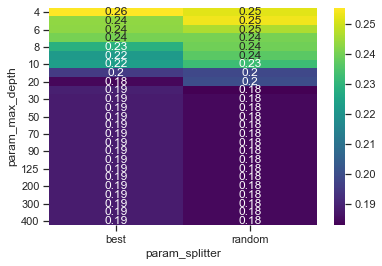

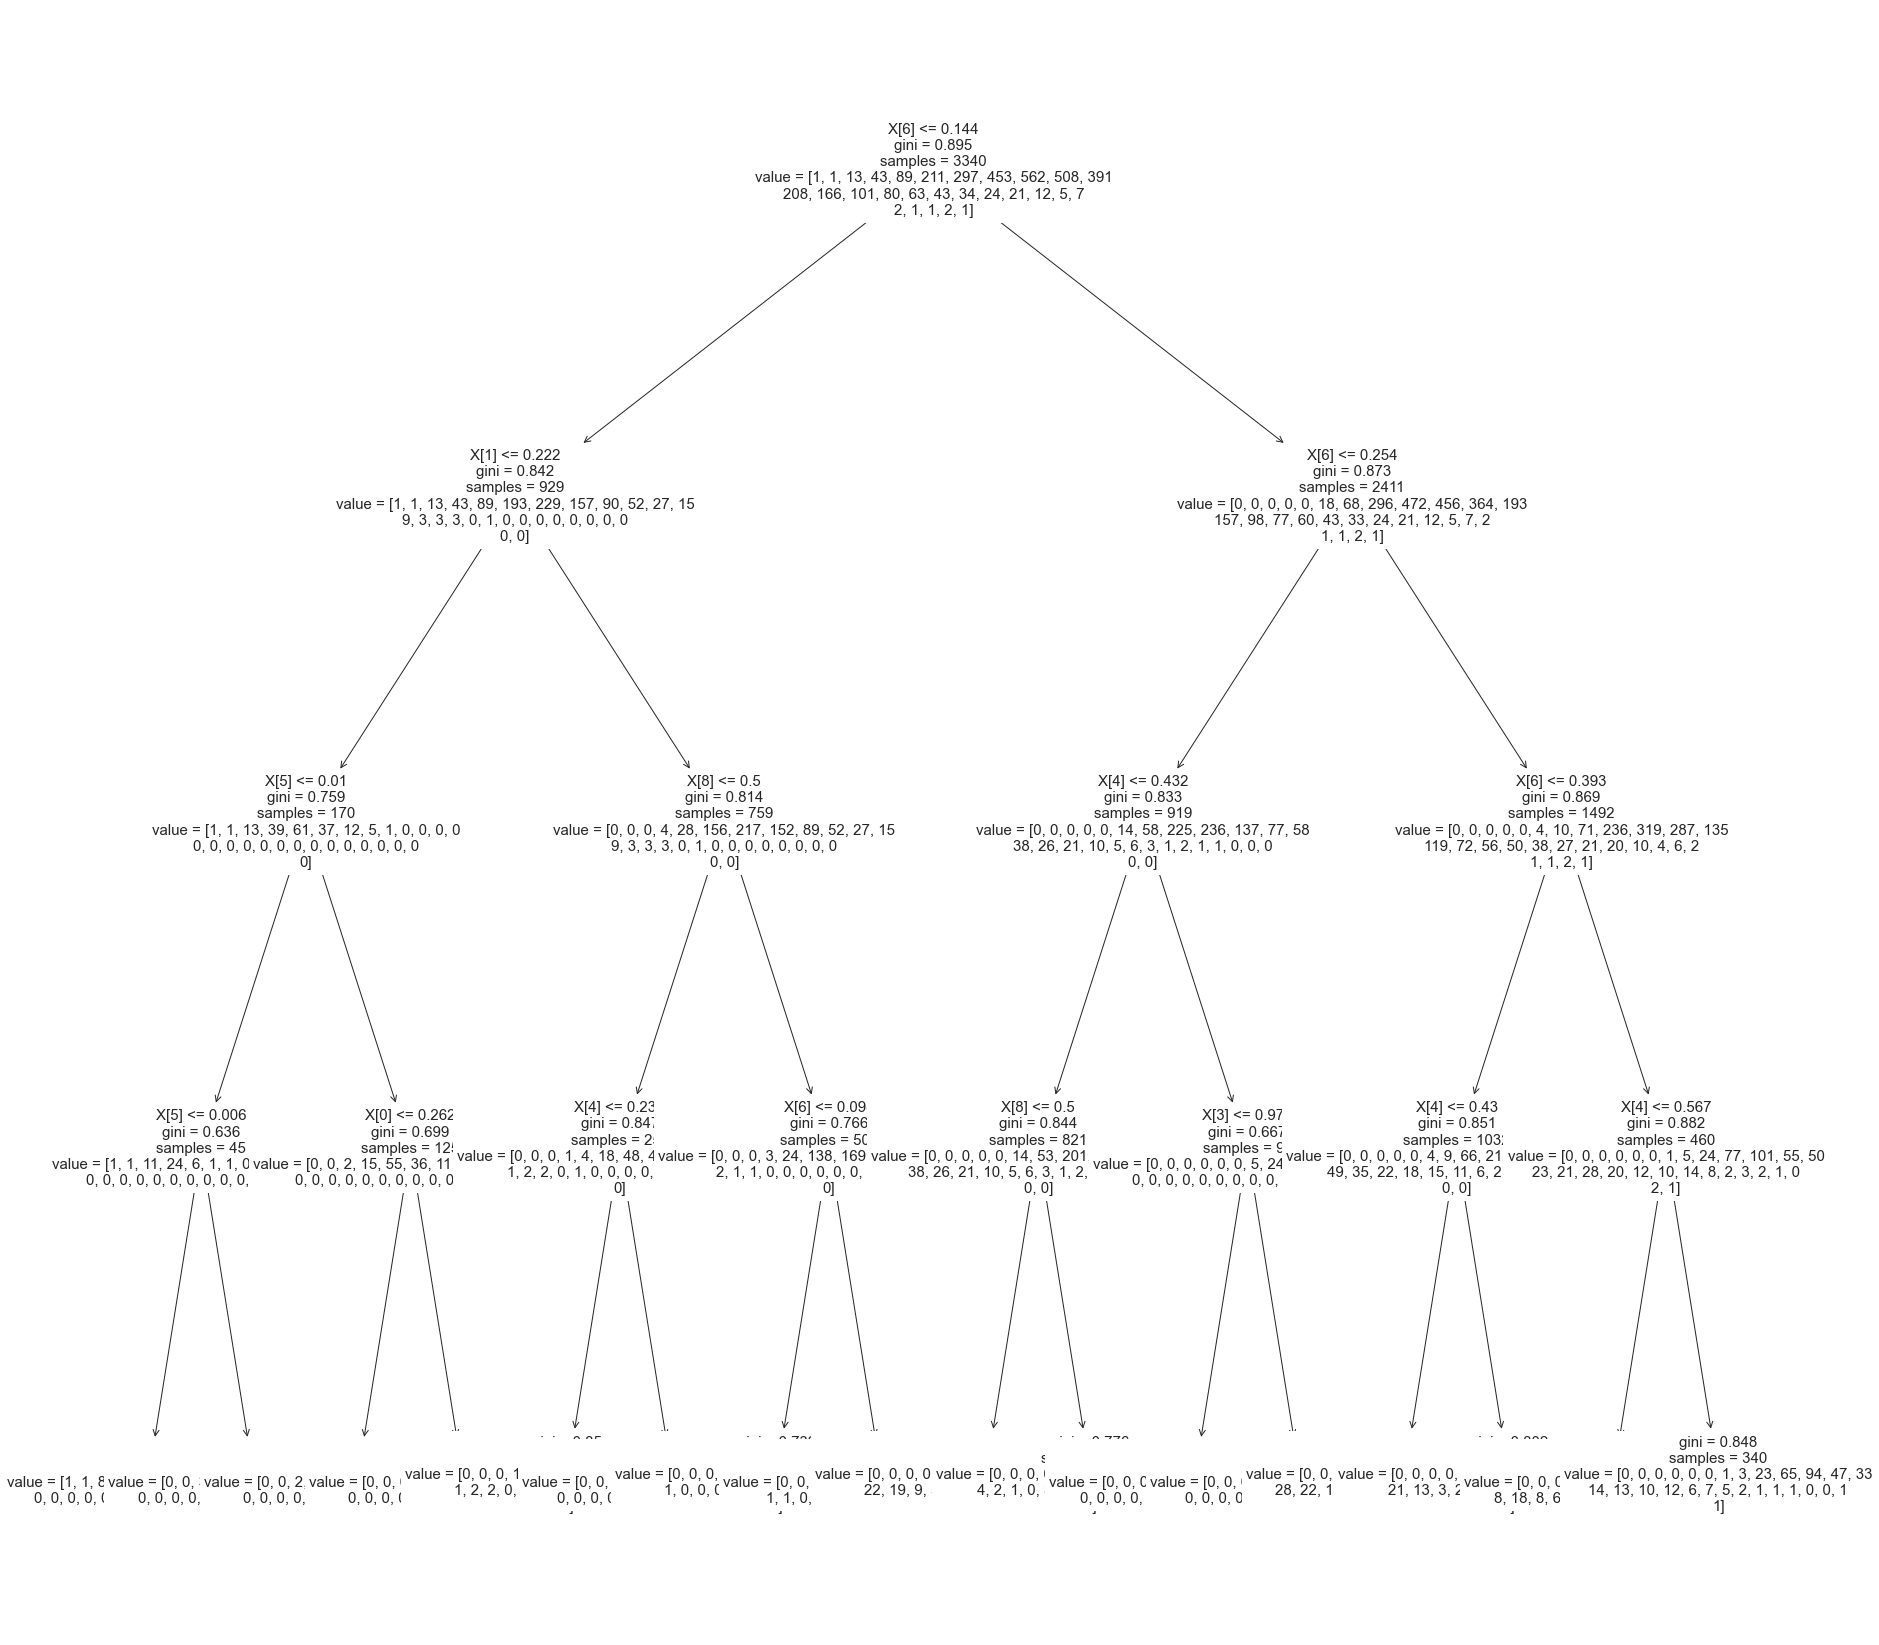

decision Tree, {'criterion': 'entropy', 'max_depth': 4} Abalone raw, 0.284688995215311


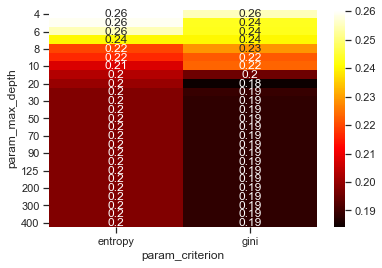

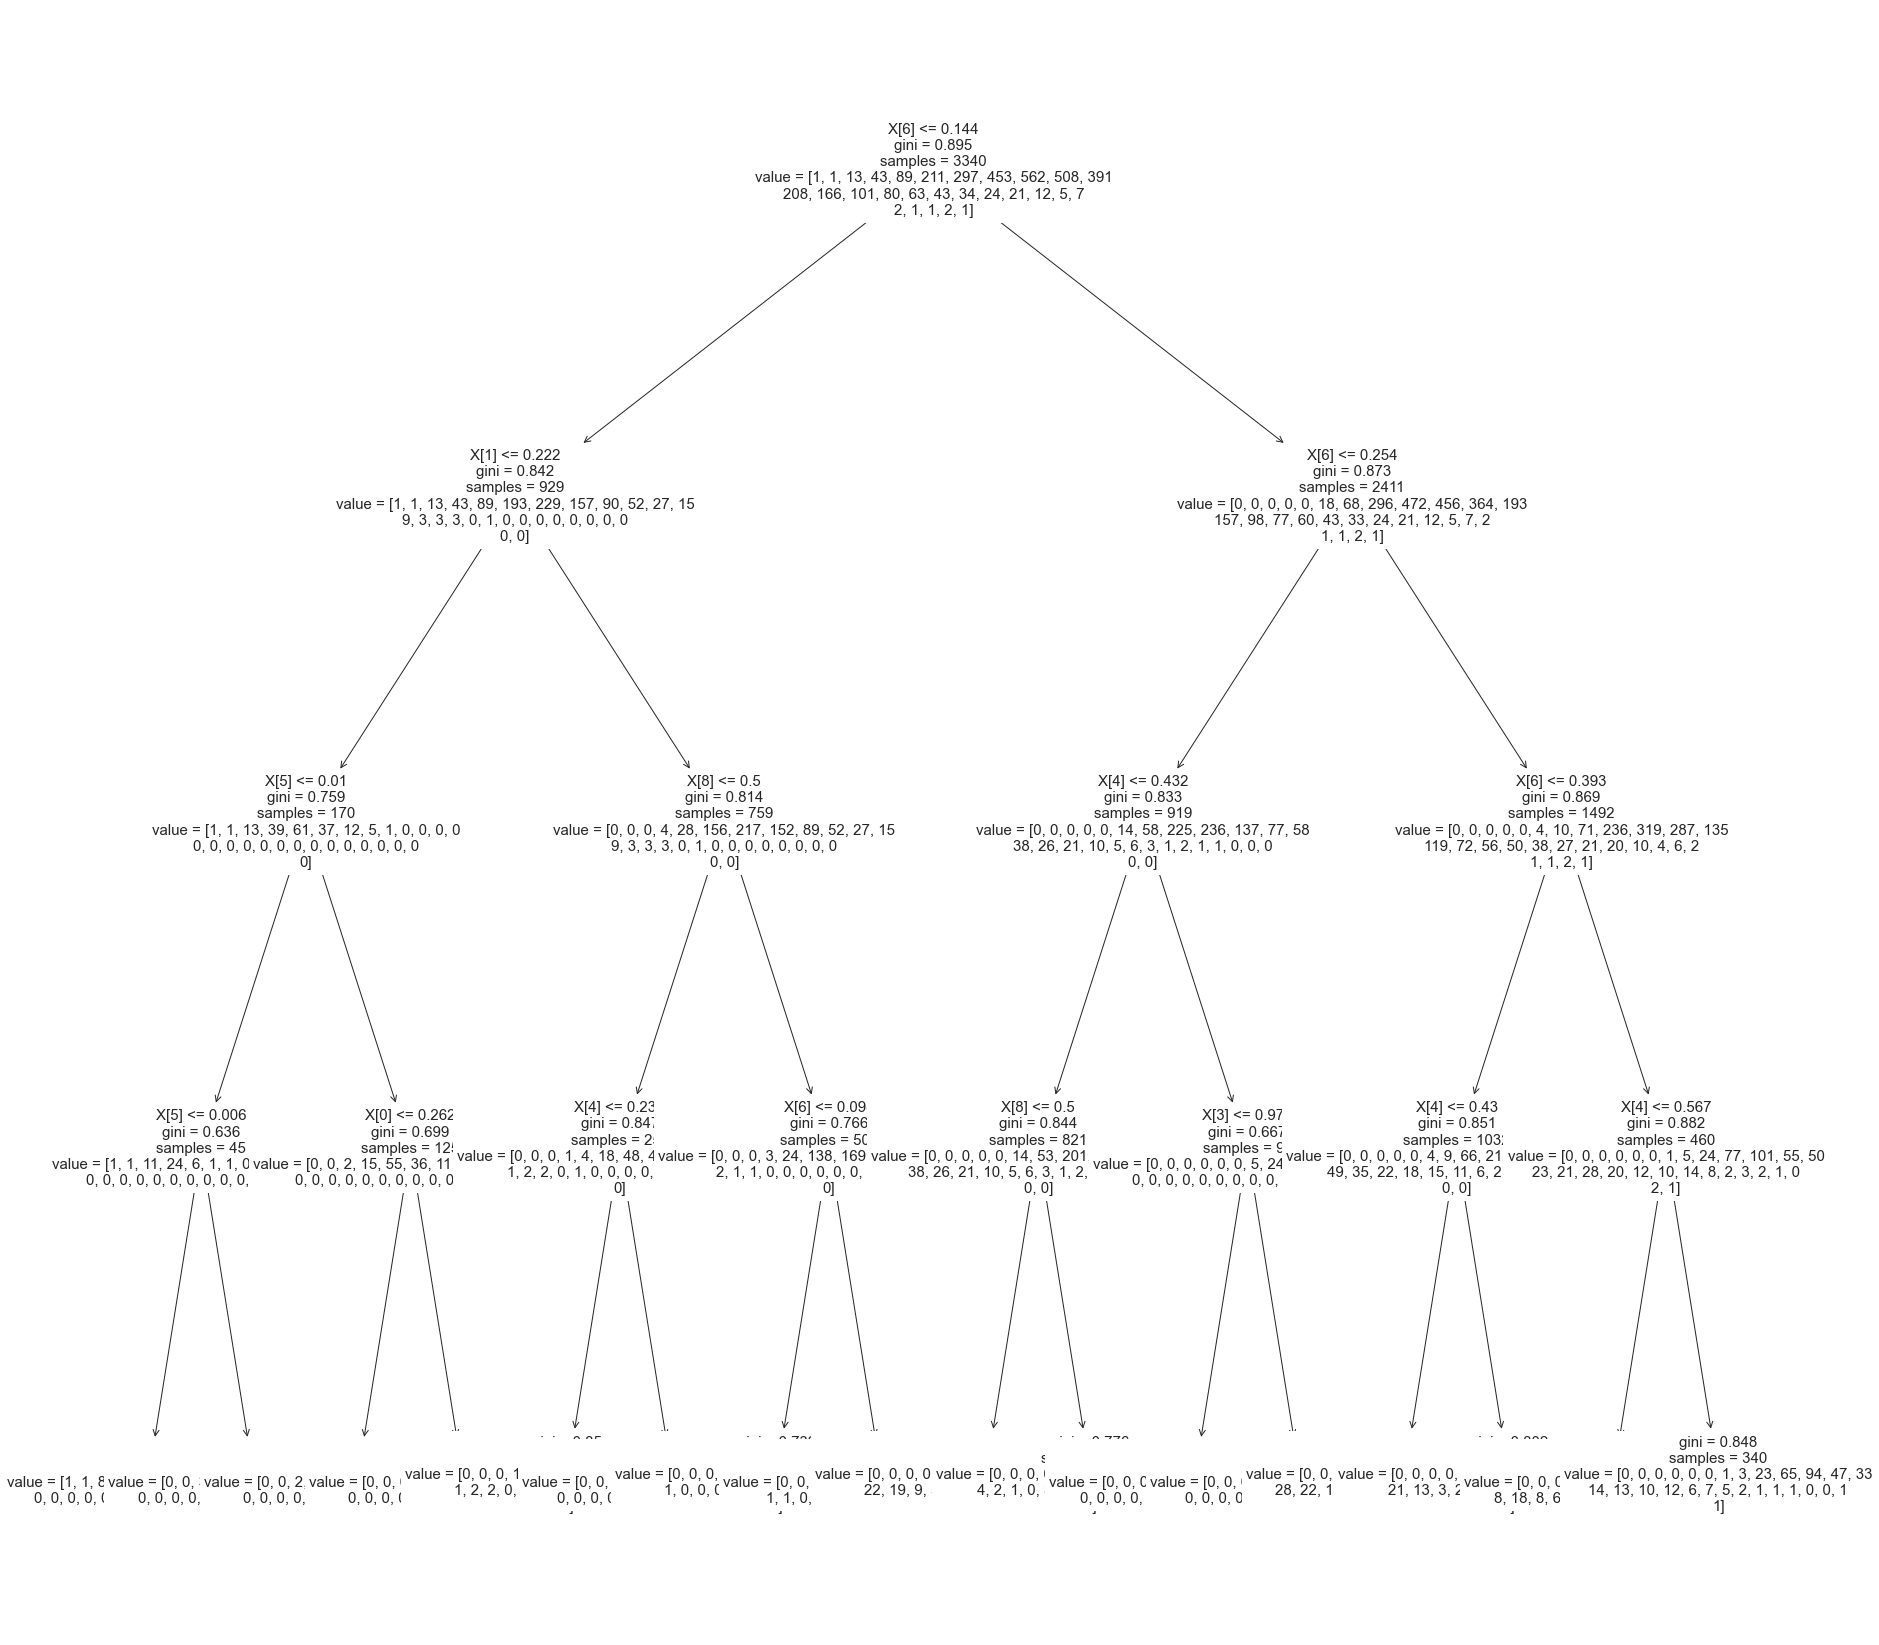

decision Tree, {'max_depth': 30, 'splitter': 'best'} Wine raw, 0.5961538461538461


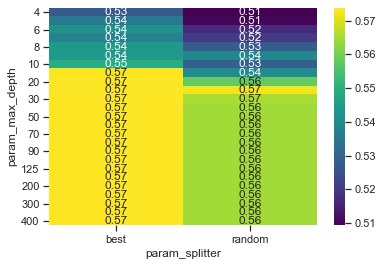

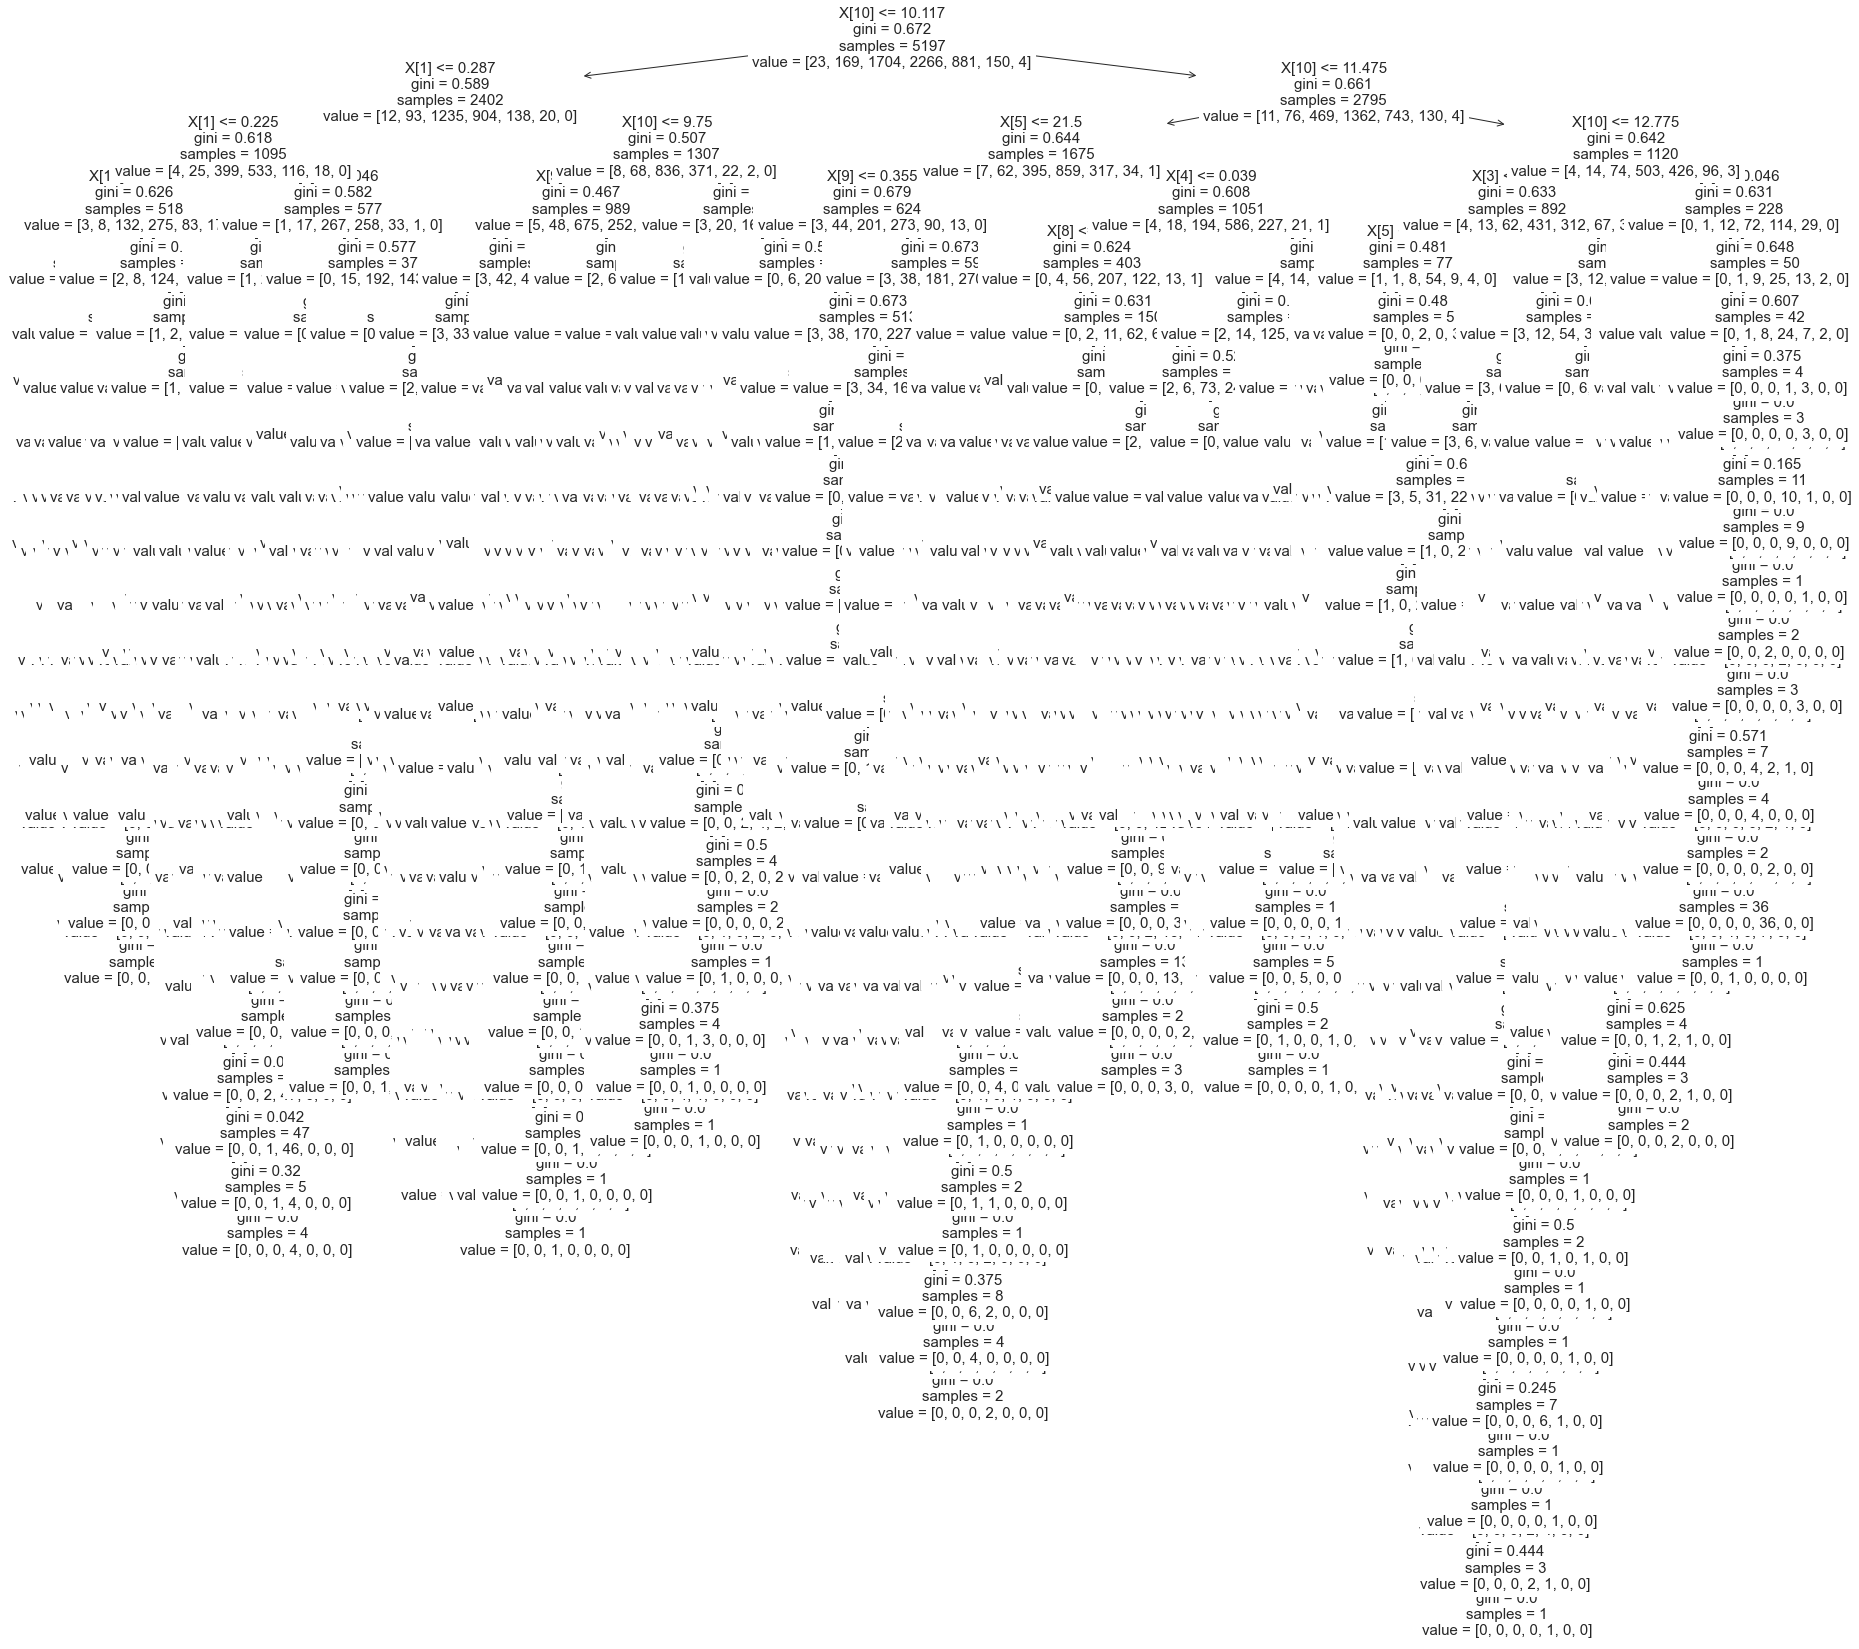

decision Tree, {'criterion': 'entropy', 'max_depth': 20} Wine raw, 0.5961538461538461


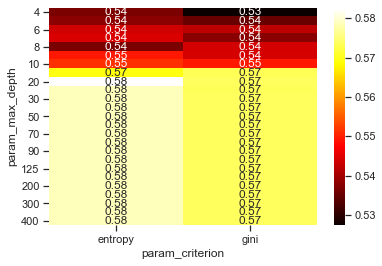

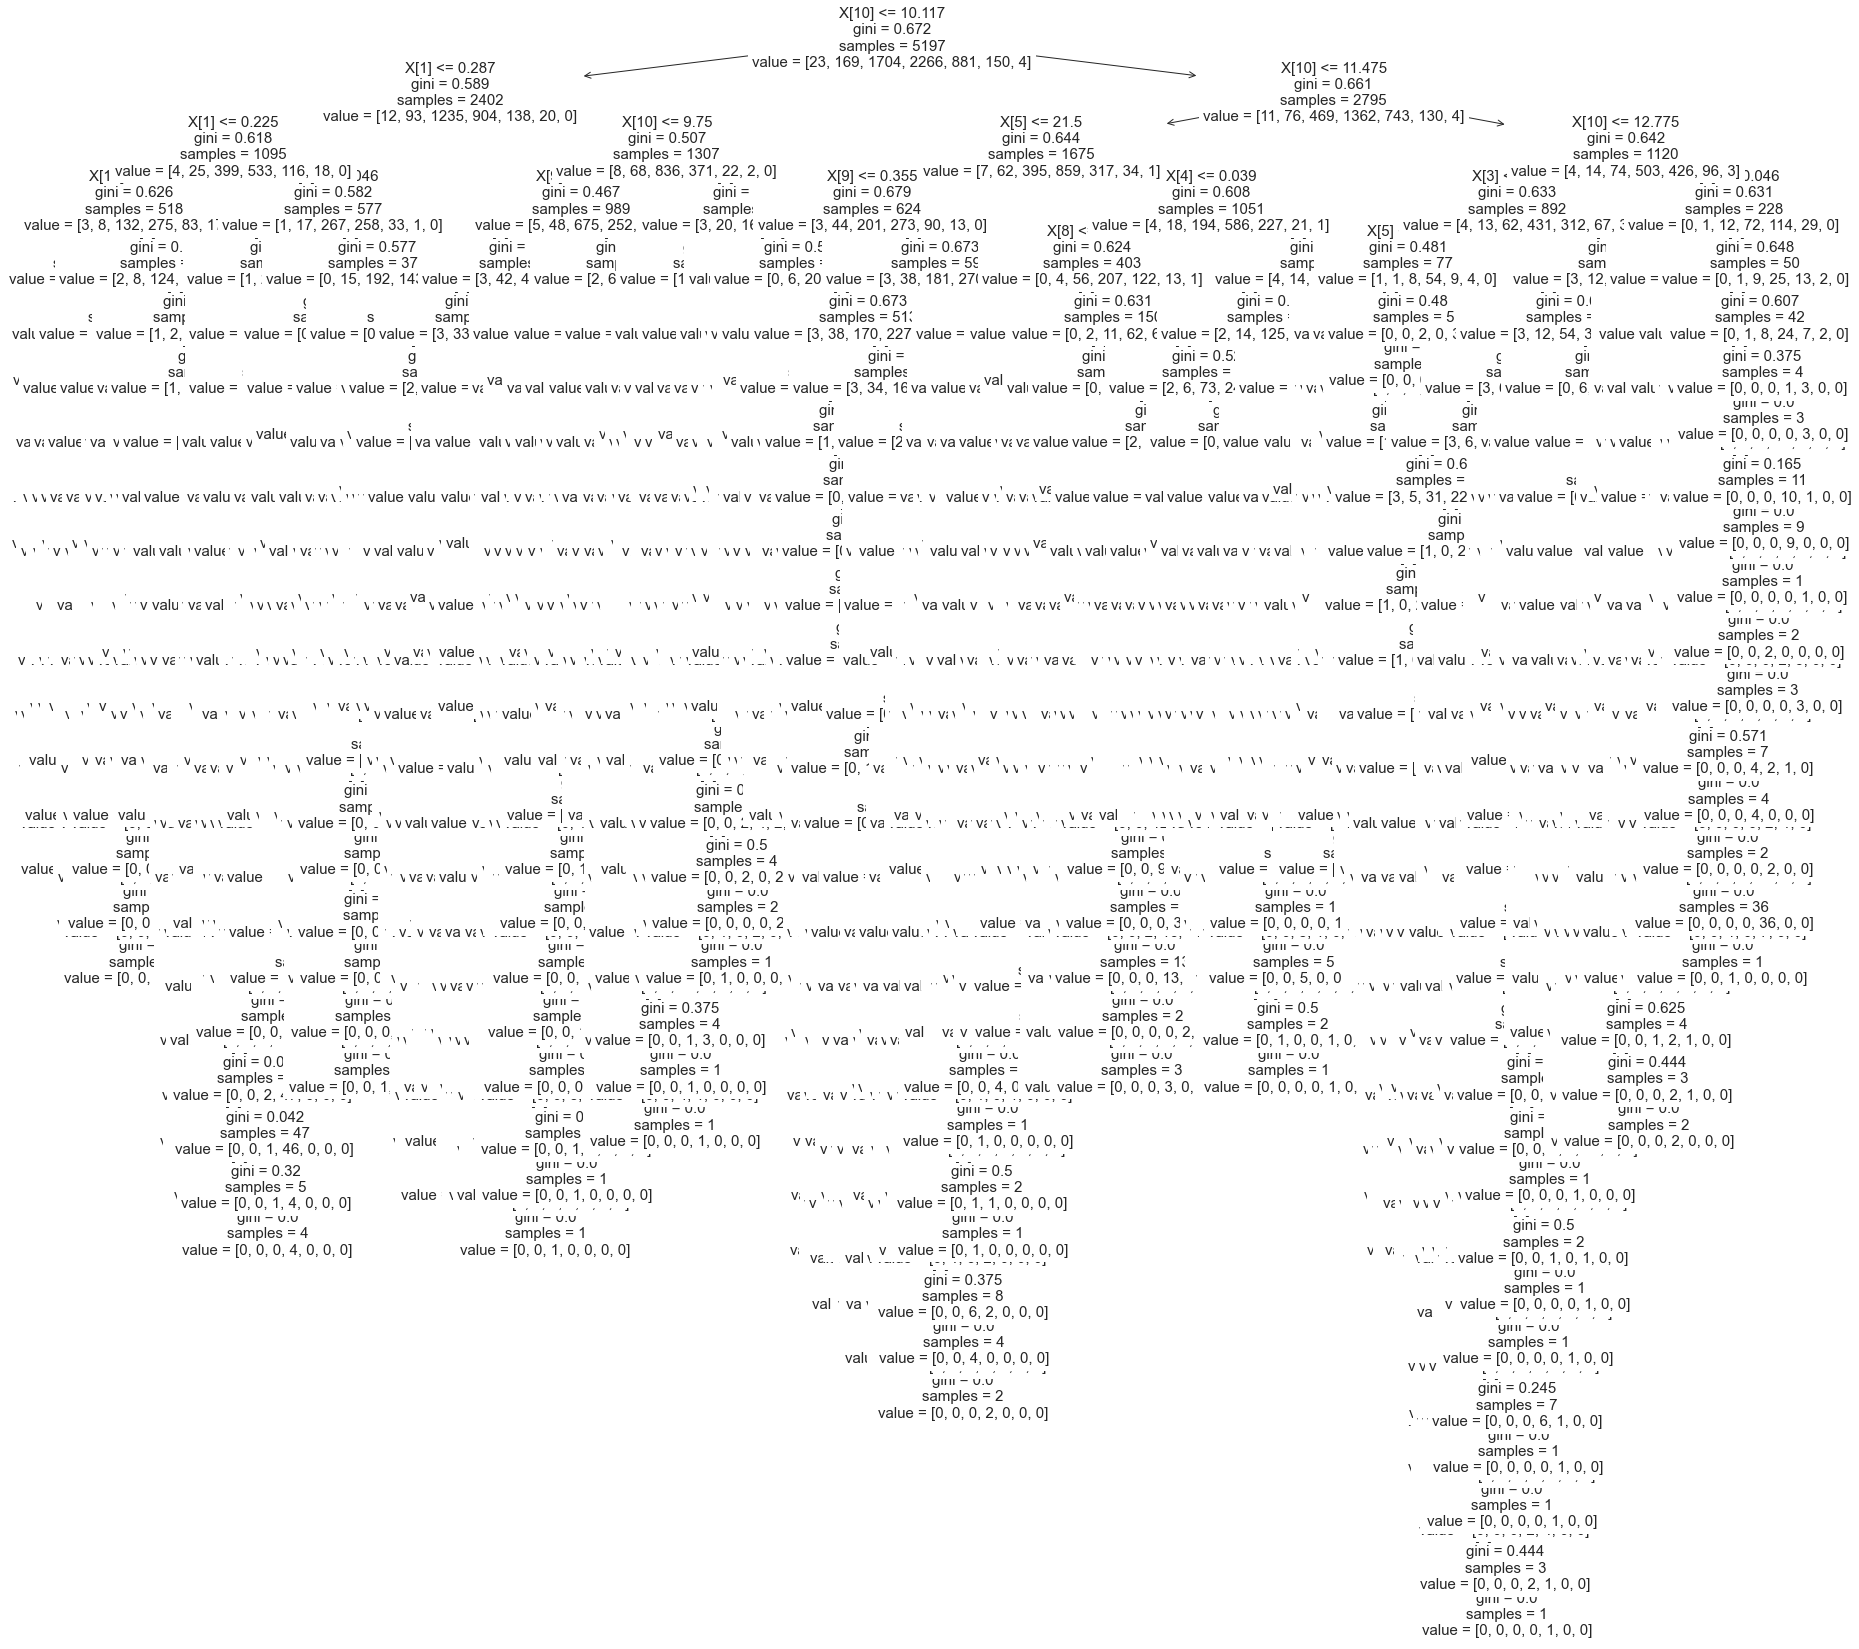

In [66]:
for i in range(0,6,3):
    dataset= six_datasets[i]

    if(i<=2):
        y= abalone_Y
    else:
        y = wine_Y
        
    params = {'max_depth':[4,5,6,7,8,9,10,15,20,25,30,40,50,60,70,80,90,100,125,150,200,250,300,350,400], 'splitter' :['best', 'random']}
    params1 = {'max_depth':[4,5,6,7,8,9,10,15,20,25,30,40,50,60,70,80,90,100,125,150,200,250,300,350,400], 'criterion' :['gini', 'entropy']}
    X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=testsize,random_state=ran)
    
    clf = GridSearchCV(DecisionTreeClassifier(random_state=ran), params, cv=5,scoring="accuracy")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)

    print('decision Tree, '+ str(clf.best_params_) + ' '+ six_datasets_name[i] + ', ' + str(test_accuracy))
    
    clf1 = GridSearchCV(DecisionTreeClassifier(random_state=ran), params1, cv=5,scoring="accuracy")
    clf1.fit(X_train, y_train)
    y_pred1 = clf.predict(X_test)
    test_accuracy1 = metrics.accuracy_score(y_test,y_pred)

    pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_splitter')
    
    
    pvt2 = pd.pivot_table(pd.DataFrame(clf1.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_criterion')
     
    sns.heatmap(pvt, cmap='viridis', annot=True)
    plt.show()
    
    plt.figure(figsize=(30,30))
    tree.plot_tree(clf.best_estimator_, fontsize = 15)
    plt.show()
    
    print('decision Tree, '+ str(clf1.best_params_) + ' '+ six_datasets_name[i] + ', ' + str(test_accuracy1))
    
    sns.heatmap(pvt2, cmap='hot', annot=True)
    plt.show()
    
    plt.figure(figsize=(30,30))
    tree.plot_tree(clf.best_estimator_, fontsize = 15)
    plt.show()

We have plotted the heatmaps for each of grid search ( max depth vs splitter, max depth vs criterion). Lighter colors depicts better accuracy. From the 4 heatplots we can conclude that for the 'best' splitter and for 'entropy' criterion we are seeing the max accuracy while having lower max tree depth.

For Abalone Raw Datsset, we can observe that as we increase the max_depth the accuracy decreases and we get maximum accuarcy 
when max_depth is in the range of [4, 7].

For the Wine Raw Dataset, we can observe that as we increase the max_depth the accuarcy increases till max_depth reaches the value of 30, and after that it is stagnant.

## 4. Random Forest Classifier

#### 4.1 Use 5-fold cross validation and a range of parameter values to evaluate the best settings for classification on each dataset. 
#### • the maximum depth of trees, you can try values as low as 2 or 3 and as high as needed, decision trees have an upper limit on how deep they can go determine by the size of the dataset.
#### • the number of trees, try values at regular intervals, you can go as low as 3 and as high as a few hundred trees.

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
mdepth_range = [2,4,5,6,7,10,15,20,50,100]
n_estimators = [3,5,10,15,20,25,50,75,100,150,200,250]

for i in range(6):
    dataset= six_datasets[i]

    if(i<=2):
        y= abalone_Y
    else:
        y = wine_Y
        
    params = {'max_depth': mdepth_range, 'n_estimators': n_estimators}
    
    X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=testsize,random_state=ran)
    
    clf = GridSearchCV(RandomForestClassifier(random_state=ran,n_jobs=8), params, cv=5,scoring="accuracy")

    clf.fit(X_train, y_train)
    
    means = clf.cv_results_
    y_pred = clf.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    
    print('Random Forest, '+ str(clf.best_params_) + ' '+ six_datasets_name[i] + ', ' + str(test_accuracy))

Random Forest, {'max_depth': 4, 'n_estimators': 50} Abalone raw, 0.2942583732057416
Random Forest, {'max_depth': 5, 'n_estimators': 100} Abalone PCA, 0.2811004784688995
Random Forest, {'max_depth': 6, 'n_estimators': 100} Abalone LDA, 0.291866028708134
Random Forest, {'max_depth': 50, 'n_estimators': 250} Wine raw, 0.6892307692307692
Random Forest, {'max_depth': 20, 'n_estimators': 250} Wine PCA, 0.6723076923076923
Random Forest, {'max_depth': 20, 'n_estimators': 100} Wine LDA, 0.6684615384615384


#### 4.2 Produce a plot showing the mean accuracy above parameter settings. This can be done as a heat plot showing a grid of mean accuracies for different combinations of the two parameters.

Random Forest, {'max_depth': 4, 'n_estimators': 50} Abalone raw, 0.2942583732057416


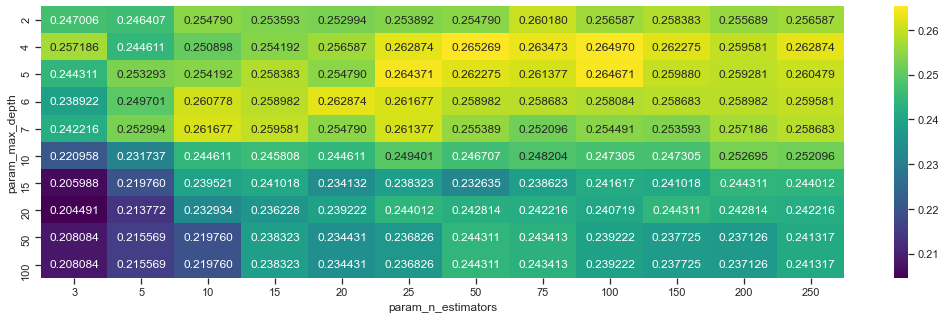

Random Forest, {'max_depth': 5, 'n_estimators': 100} Abalone PCA, 0.2811004784688995


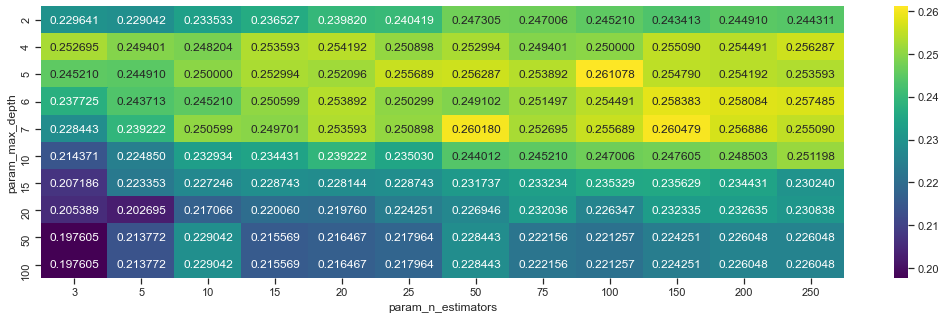

Random Forest, {'max_depth': 6, 'n_estimators': 100} Abalone LDA, 0.291866028708134


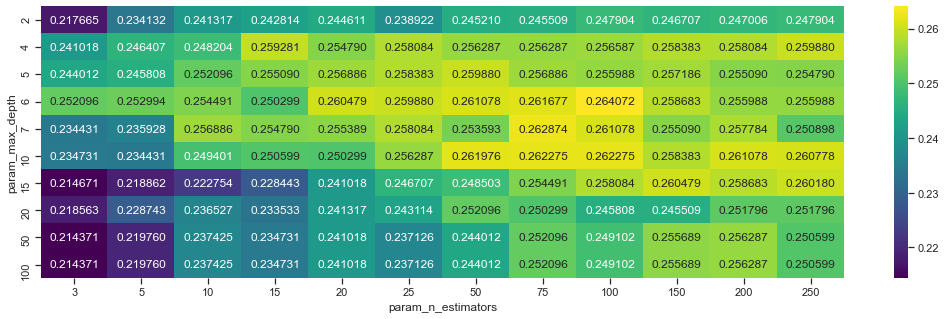

Random Forest, {'max_depth': 50, 'n_estimators': 250} Wine raw, 0.6892307692307692


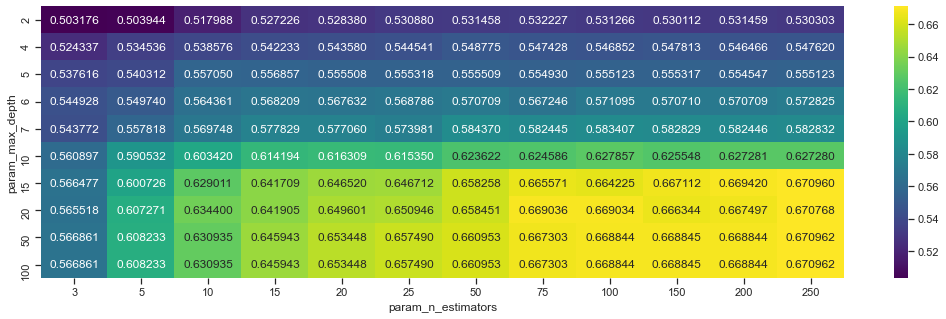

Random Forest, {'max_depth': 20, 'n_estimators': 250} Wine PCA, 0.6723076923076923


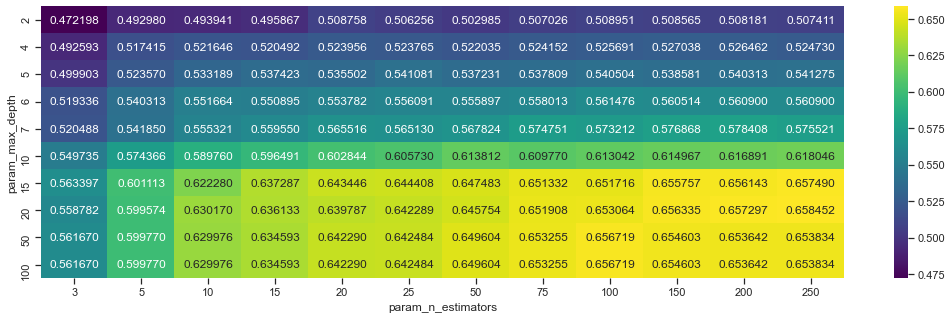

Random Forest, {'max_depth': 20, 'n_estimators': 100} Wine LDA, 0.6684615384615384


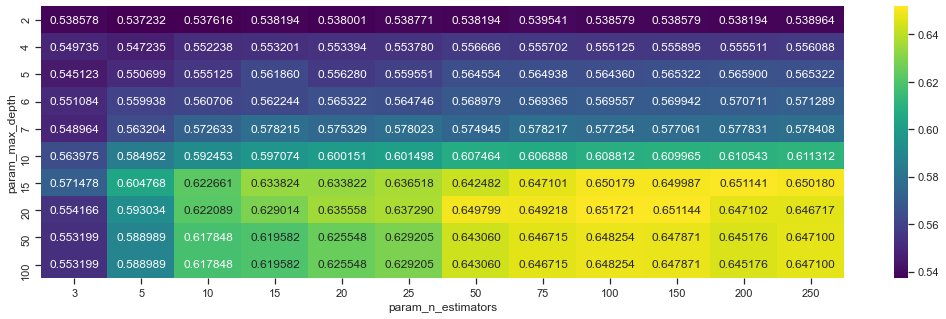

In [63]:
mdepth_range = [2,4,5,6,7,10,15,20,50,100]
n_estimators = [3,5,10,15,20,25,50,75,100,150,200,250]

for i in range(6):
    dataset = six_datasets[i]
    if(i<=2):
        y= abalone_Y
    else:
        y = wine_Y
        
    params = {'max_depth': mdepth_range, 'n_estimators': n_estimators}
    
    X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=testsize,random_state=ran)
    
    clf = GridSearchCV(RandomForestClassifier(random_state=ran,n_jobs=8), params, cv=5,scoring="accuracy")

    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    
    print('Random Forest, '+ str(clf.best_params_) + ' '+ six_datasets_name[i] + ', ' + str(test_accuracy))
    
    pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
    
    plt.figure(figsize=(18,5))
    sns.heatmap(pvt, annot=True, fmt='f', cmap='viridis')
    plt.show()

For the Abalone dataset we can see the lighter shades on the top right cornor, which implies that the model fits better with more number of estimators. Based on the bottom of the plots, we can see that as the max depth increases, it is overfitting which leads to a drop of accuracy for the same number of estimators. Hence we can say that for the abalone dataset, random forest generetes trees of small heights.On the other hand, for the wine dataset we can see the lighter shades on the bottom right cornor, which implies that the model fits better with more number of estimators and greater the depth. Based on the top half and left half of the plots, we can see that for lower max depth and lower number of estimators, it is underfitting leading to lower accuracy scores . Hence we can say that for the Wine dataset, random forest generetes trees of larger heights.

## 5. Gradient Tree Boosting

#### 5.1 Use 5-fold cross validation and a range of parameter values to evaluate the best settings for classification on each dataset. The number of estimators, try values at regular intervals, you can go as low as 3 and as high as a few hundred estimators. Note: the number of ‘trees’ grown by GBT is n classes × n estimators but this is handled automatically.
#### 5.2 Produce a plot showing the mean accuracy above parameter settings

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

Gradient Boosting, {'n_estimators': 20} Abalone raw, 0.2703349282296651


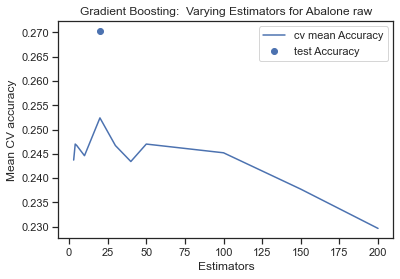

Gradient Boosting, {'n_estimators': 10} Abalone PCA, 0.26435406698564595


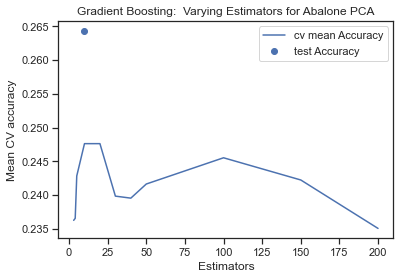

Gradient Boosting, {'n_estimators': 30} Abalone LDA, 0.2583732057416268


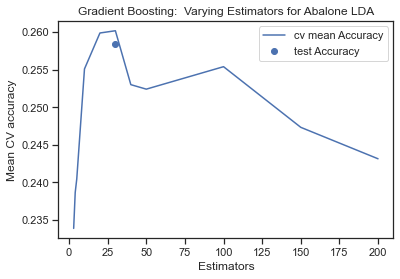

Gradient Boosting, {'n_estimators': 200} Wine raw, 0.6107692307692307


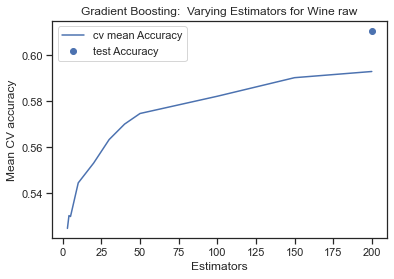

Gradient Boosting, {'n_estimators': 200} Wine PCA, 0.5915384615384616


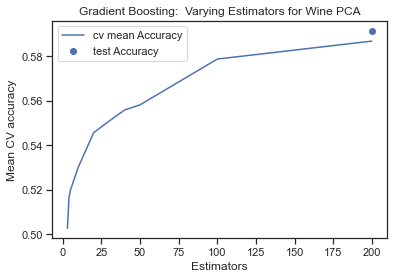

Gradient Boosting, {'n_estimators': 200} Wine LDA, 0.5976923076923077


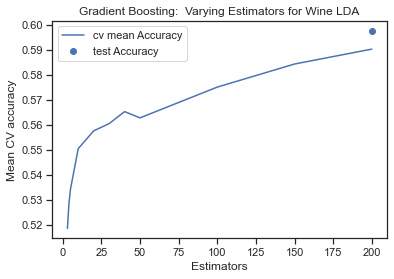

In [28]:
for i in range(6):
    dataset= six_datasets[i]
 
    if(i<=2):
        y= abalone_Y
    else:
        y = wine_Y
 
    params = { 'n_estimators': [3,4,5,10,20,30,40,50,100,150,200]}
 
    X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=testsize,random_state=ran)

    clf = GridSearchCV(GradientBoostingClassifier(random_state=ran), params, cv=5,scoring="accuracy")
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)

    print('Gradient Boosting, '+ str(clf.best_params_) + ' '+ six_datasets_name[i] + ', ' + str(test_accuracy))

    plt.title('Gradient Boosting:  Varying Estimators for ' + str( six_datasets_name[i]))
    plt.plot(clf.cv_results_['param_n_estimators'],clf.cv_results_['mean_test_score'], label = 'cv mean Accuracy')
    plt.scatter(clf.best_params_['n_estimators'],test_accuracy, label = 'test Accuracy')
    plt.legend()
    plt.xlabel('Estimators')
    plt.ylabel('Mean CV accuracy')
    plt.show()

For the Abalone dataset we can see that as the number of estimators increases, initially we see a spike in the accruracy, after that as the number of estimators increase, the accuracy decreases. This implies that for higher number of estimators, we are overfitting the model leading to decreasing accuracies.

On the other hand, for the wine dataset we can observe that as the number of estimators increase, the accuracy is increasing. Intially it is very low, but it is increasing gradully.

## 6. Final Results

#### 6.1 Comment on which pipeline resulted in the best classification accuracy overall, or for each dataset

For Abalone Dataset the best accuracy was by KNN on raw dataset and its pipeline is - raw dataset -> min-max normalization -> .2/.8 split -> k=78, distance = manhattan
For Wine Dataset the best accuracy was by KNN on raw dataset and its pipeline is - raw dataset -> min-max normalization -> .2/.8 split -> k=58, distance = manhattan

#### 6.2 What was the effect of Dimensionality Reduction on the different algorithms. Did some benefit from it more than others? Explain why this might be.

For wine datasets with 5 primary components (covering 90% of variance), dimensionality reduction by PCA has almost the same accuracy as the wine raw dataset. When compared to wine raw data, dimension reduction by LDA appears to have a 10% worse accuracy. PCA reduced characteristics in the Abalone data set to two main components. PCA performed best with decision trees in the Ablalone datasets, whereas LDA performed better with random forest and gradient trees.

#### 6.3 Feel free to make additional observations about the results beyond these

We can see from the table that the Random forest functioned best with all 6 datasets (wine and abalone), but the Naïve bayes had the lowest accuracy metrics because to their naive nature. As seen by the RF performance on the Abalone and Wine Datasets, having more estimators does not always guarantee we can fit the data better.

#### 6.4 Produce results tables summarizing all the final results in the following general form:

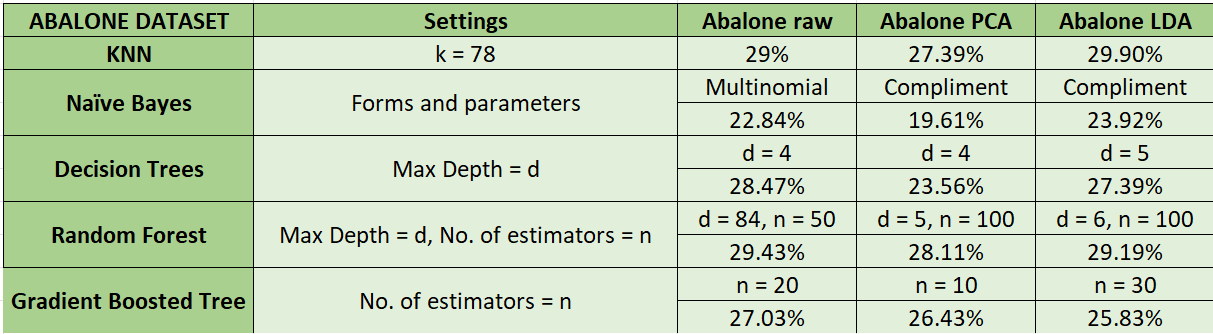

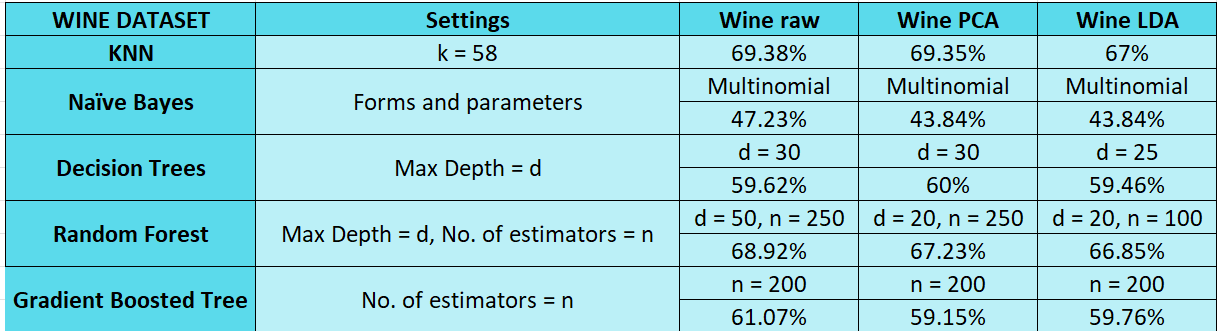

<h2>Refrences </h2>

<ul>
<li><hr>https://scikit-learn.org/stable/modules/naive_bayes.html
<li><hr>https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf
<li><hr> https://stackoverflow.com/questions/46756606/what-does-splitter-attribute-in-sklearns-decisiontreeclassifier-do
<li> <hr>https://archive.ics.uci.edu/ml/datasets/abalone
<li><hr> https://archive.ics.uci.edu/ml/datasets/wine
<li><hr> https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d
<li><hr>https://stackoverflow.com/questions/46756606/what-does-splitter-attribute-in-sklearns-decisiontreeclassifier-do
<li><hr> http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html
<li><hr> https://seaborn.pydata.org/generated/seaborn.heatmap.html
<li><hr> https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c
<li><hr> Assignment 1, student 2 starter IPYNB file
<li><hr> https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
    
</ul>